In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ebmdatalab import bq, maps, charts
import matplotlib.gridspec as gridspec

In [7]:
sql= '''
SELECT
month,
  pct,
  register_size AS dementia_register,
  SUM(items) AS items,
  SUM(actual_cost) AS cost
FROM
  ebmdatalab.hscic.normalised_prescribing_standard AS presc
INNER JOIN
  ebmdatalab.hscic.qof_ccgs_1415 AS ccg ##1415 register - update if we do anything with it
ON
  presc.pct = ccg.ccg_code
WHERE
  (bnf_code LIKE "0409010M%" OR ##Memantine
    bnf_code LIKE "0411000D0%" OR ##Donepezil
    bnf_code LIKE "0411000F0%" OR  ##Galantamine
    bnf_code LIKE "0411000E0%")
    AND ccg.indicator_code = "DEM"
   GROUP BY
   month,
   pct,
   register_size
 '''

df_dementia = bq.cached_read(sql, csv_path='dementia.csv')
df_dementia.head(10)

,month,pct,dementia_register,items,cost
0,2010-10-01,00C,1021,665,26670.66000
1,2018-11-01,00C,1021,786,4729.43696
2,2016-02-01,00C,1021,886,4927.32000
3,2013-02-01,00C,1021,703,7829.17000
4,2010-09-01,00C,1021,678,26955.64000
5,2018-12-01,00C,1021,820,4637.32320
6,2011-09-01,00C,1021,743,29758.22000
7,2013-10-01,00C,1021,828,7709.09000
8,2018-10-01,00C,1021,881,5363.48552
9,2015-11-01,00C,1021,741,4581.05000


In [8]:
df_dementia['item per dem patient'] = df_dementia['items'] / df_dementia['dementia_register']
df_dementia.head(5)

,month,pct,dementia_register,items,cost,item per dem patient
0,2010-10-01,00C,1021,665,26670.66000,0.651322
1,2018-11-01,00C,1021,786,4729.43696,0.769833
2,2016-02-01,00C,1021,886,4927.32000,0.867777
3,2013-02-01,00C,1021,703,7829.17000,0.688541
4,2010-09-01,00C,1021,678,26955.64000,0.664055


In [11]:
from ebmdatalab import charts
import matplotlib.gridspec as gridspec
f = plt.figure(figsize=(14, 5))
#f.suptitle('Sharing Y axis')
f.autofmt_xdate()
layout = gridspec.GridSpec(1, 2, figure=f)
left_plot = plt.subplot(layout[0])
right_plot = plt.subplot(layout[1], sharey=left_plot)  # Share the Y axis 
# ...and because it's shared, suppress ticks on the second chart
plt.setp(right_plot.get_yticklabels(), visible=False)  

charts.deciles_chart(
    df_dementia,
    period_column='month',
    column='item per dem patient',
    title="(a) CCG variation",
    ylabel="Dementia Rx per patient on dementia register",
    show_outer_percentiles=True,
    show_legend=False,
    ax=left_plot
)

charts.deciles_chart(
    df_dementia,
    period_column='month',
    column='items',
    title="(b) Practice variation",
    ylabel="",
    show_outer_percentiles=True,
    show_legend=False,
    ax=right_plot
)
plt.savefig('deciles.png', format='png', dpi=300,bbox_inches='tight')
plt.show()

ValueError: DateFormatter found a value of x=0, which is an illegal date.  This usually occurs because you have not informed the axis that it is plotting dates, e.g., with ax.xaxis_date()

ValueError: DateFormatter found a value of x=0, which is an illegal date.  This usually occurs because you have not informed the axis that it is plotting dates, e.g., with ax.xaxis_date()

<Figure size 4200x1500 with 2 Axes>

In [12]:
df_dem_18 = df_dementia.loc[(df_dementia["month"]>="2018-01-01") & (df_dementia["month"]<="2018-01-01")]
df_dem_18.head()

,month,pct,dementia_register,items,cost,item per dem patient
83,2018-01-01,00C,1021,876,4799.78663,0.857982
131,2018-01-01,00D,2809,1744,10901.13821,0.620862
248,2018-01-01,00J,1997,1910,11405.45657,0.956435
372,2018-01-01,00K,2784,1327,14933.09383,0.476652
439,2018-01-01,00L,2976,2010,12006.99144,0.675403


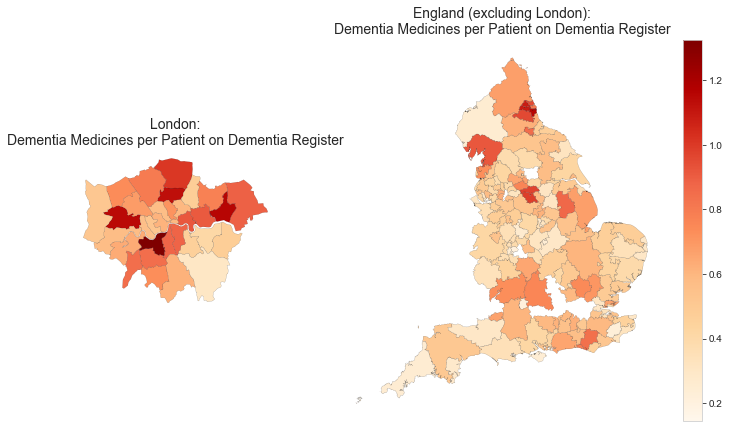

In [13]:
plt.figure(figsize=(12, 7))
maps.ccg_map(df_dem_18, title="Dementia Medicines per Patient on Dementia Register", column='item per dem patient', 
             separate_london=True)
plt.savefig('map.png', format='png', dpi=300,bbox_inches='tight')
plt.show()